In [1]:
import pandas as pd
import script_reglas

import nltk as nltk
from emoji import UNICODE_EMOJI
import unicodedata as unicodedata
import re
from __future__ import print_function
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
! ls ./datos/


comparacion.csv         explora_loadings.csv    results_export_964.xlsx
etiquetado.csv          exploracion
etiquetado_pepe.csv     flujos_peticiones.csv


In [3]:
respuestas=pd.read_excel('./datos/results_export_964.xlsx', encoding='utf-8')

In [4]:
respuestas=respuestas[['Contact UUID', 'URN', 'Name', 'Groups', 'Response 9 (Text) - uncaught']]
respuestas.columns=['id_contacto', 'urn', 'nombre_contacto', 'listas', 'texto']

In [5]:
categoria_reglas=pd.DataFrame()
for i in range(0, respuestas.shape[0]):
    respuesta_regla=pd.DataFrame(script_reglas.procesa_reglas(str(respuestas['texto'].iloc[i])), index=[i])
    categoria_reglas=pd.concat([categoria_reglas, respuesta_regla])
respuestas=pd.concat([respuestas[['id_contacto', 'urn', 'nombre_contacto', 'listas']],
                      categoria_reglas], axis=1)

In [6]:
print(respuestas.shape)
respuestas=respuestas.loc[respuestas.texto!='nan']
print(respuestas.shape)

(3045, 9)
(2472, 9)


In [14]:
respuestas.result.value_counts()

modelo           976
like-fb          480
si               309
gracias          184
hola             136
no               114
informacion       96
ok                95
emoji             36
spam              23
twitter-image     13
hasta luego        6
pregunta           4
Name: result, dtype: int64

In [15]:
etiquetado=pd.read_csv('./datos/etiquetado_pepe.csv')

In [16]:
etiquetado.head()

,id_contacto,urn,nombre,listas,uncaught_resp_9_cat,uncaught_resp_9_val,uncaught_resp_9_text,categ_opi,uncaught_resp_9_text_wc,uncaught_resp_9_text_nchar,uncaught_resp_9_text_mod,es
0,e7e51622-a160-4bb4-9b7d-785c0c2bfbc7,20999,NaN,NaN,Other,La solicitud de enviar el SMS por Cobrar a 552...,la solicitud de enviar el sms por cobrar a 552...,6,24,144,la solicitud de enviar el sms por cobrar a 552...,0
1,313822ff-7541-4db6-8fe1-a252363000ab,522461582793,sarahi,"ALL, ALTOPD",no,no,te llame y no pude localizarte. tramita en lin...,6,24,135,te llame y no pude localizarte tramita en line...,0
2,86962a26-c021-4606-8986-893834ad83bd,524271210385,NaN,"ALL, ALTOPD",Other,59508,59508,4,1,5,59508,0
3,84b7624f-261d-44b4-83ba-6fade1a44c3a,524271654479,NaN,"ALL, ALTOPD",Other,Mi bebe,mi bebe,3,2,7,mi bebe,0
4,e083b2ea-6e2d-410c-b5a4-8067a818d485,522411259330,NaN,"ALL, ALTOPD",Gracias,gracias,hola si ya cada integrante tenemos fotos con l...,3,18,99,hola si ya cada integrante tenemos fotos con l...,0


In [191]:
respuestas_etiquetas=pd.merge(respuestas, etiquetado[['id_contacto', 'categ_opi']],how='left',
                              on=['id_contacto'])

In [192]:
pd.crosstab(respuestas_etiquetas.result.fillna('missing').astype(str),
            respuestas_etiquetas.categ_opi.fillna('missing').astype(str), margins=True)

categ_opi,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,missing,All
result,,,,,,,,,,
emoji,0,0,0,0,0,2,0,0,34,36
gracias,0,0,0,0,0,1,0,0,183,184
hasta luego,0,0,0,0,0,0,0,0,6,6
hola,0,0,0,1,0,13,0,0,122,136
informacion,0,0,0,0,0,0,0,0,96,96
like-fb,0,0,0,0,0,0,0,0,480,480
modelo,10,69,13,82,323,275,61,143,0,976
no,0,0,0,0,0,0,0,0,114,114
ok,0,0,0,0,0,0,0,0,95,95


In [193]:
respuestas_etiquetas=respuestas_etiquetas.loc[respuestas_etiquetas.result=='modelo']

In [194]:
label_map={1:'emergencia',
          2:'informacion',
          3: 'nacimiento',
          4: 'respuesta',
          5: 'pregunta',
          6: 'otra',
          7: 'pregunta_busca trabajo',
          8: 'otra_queja'}

In [195]:
respuestas_etiquetas.categ_opi=respuestas_etiquetas.categ_opi.map(label_map)

## preprocesamiento

In [196]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto'].str.lower()

 ### Quitar leading y trailing spaces, quitar puntuacion

In [197]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

In [198]:
respuestas_etiquetas['n_interrogacion']=respuestas_etiquetas['texto_proc'].str.count('\\?')>0

In [199]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.replace('[^\w\s]','')

In [200]:
respuestas_etiquetas['texto_proc']=respuestas_etiquetas['texto_proc'].str.strip()

### Capturar emojis

In [201]:
es_emoji=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    es=pd.DataFrame({'es':script_reglas.is_emoji(respuestas_etiquetas['texto'].iloc[i])}, index=[0])
    es_emoji=pd.concat([es_emoji, es], ignore_index=True)
print(es_emoji.shape[0]==respuestas_etiquetas.shape[0])

True


In [202]:
respuestas_etiquetas=respuestas_etiquetas.reset_index(drop=True)

In [203]:
respuestas_etiquetas=pd.concat([respuestas_etiquetas, es_emoji], axis=1)

### Quitar emojis que quedan en el texto

In [204]:
sinemojis=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinemojis_i=script_reglas.give_emoji_free_text(respuestas_etiquetas.texto_proc.iloc[i])
    sinemojis_i=pd.DataFrame({'texto':sinemojis_i}, index=[i])
    sinemojis=pd.concat([sinemojis, sinemojis_i])
respuestas_etiquetas['texto_proc']=sinemojis

### Quitar  acentos

In [205]:
sinacentos=pd.DataFrame()
for i in range(0, respuestas_etiquetas.shape[0]):
    sinacentos_i=unicodedata.normalize('NFD', respuestas_etiquetas['texto_proc'].iloc[i]).encode('ascii', 'ignore').decode('utf-8')
    sinacentos_i=pd.DataFrame({'texto':sinacentos_i}, index=[i])
    sinacentos=pd.concat([sinacentos, sinacentos_i])
respuestas_etiquetas['texto_proc']=sinacentos

In [206]:
respuestas_etiquetas.texto_proc=respuestas_etiquetas.texto_proc.str.replace('ola|\n|buena noche|buenos dias|buen dia|buenas noches|buenas tardes|buenas tarde|buen dia|bien dia|buena tardes|buena tarde|saludos|hola', '')

### Procesar dummy de  listas

In [207]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

In [208]:
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.lower()
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace(',', '')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('con fecha', 'con_fecha')
respuestas_etiquetas.listas=respuestas_etiquetas.listas.str.replace('2 años', '2_anios')

prueba_listas=respuestas_etiquetas.listas.str.split(expand=True)
lista=[pd.get_dummies(prueba_listas[col]) for col in prueba_listas]

for i in range(0, len(lista)):
    lista[i]['indice'] = lista[i].index
lista=pd.concat(lista, ignore_index=True)
prueba_listas=lista.groupby('indice', as_index=True).agg('sum')

Eliminar listas con pocas personas

In [209]:
prueba_listas=prueba_listas[prueba_listas.sum()[~(prueba_listas.sum()<=3)].keys()]

### TF-DF

In [210]:
stop=nltk.corpus.stopwords.words("spanish")

In [211]:
for i in range(0, np.shape(stop)[0]):
    stop[i]=unicodedata.normalize('NFD', stop[i]).encode('ascii', 'ignore').decode('utf-8')

In [212]:
stemmer = SnowballStemmer("spanish")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [214]:
#stemmed=pd.DataFrame()
#for i in range(0, respuestas_etiquetas.shape[0]):
#    stemmed_i=' '.join(tokenize_and_stem(respuestas_etiquetas.texto_proc[i]))
#    stemmed_i=pd.DataFrame({'texto':stemmed_i}, index=[i])
#    stemmed=pd.concat([stemmed, stemmed_i])
#respuestas_etiquetas.texto_proc=stemmed

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=([1, 2]),
                        stop_words=stop)
features = tfidf.fit_transform(respuestas_etiquetas.texto_proc).toarray()
labels = respuestas_etiquetas.categ_opi
features.shape

(976, 544)

In [216]:
x_target=respuestas_etiquetas.categ_opi
x_train=respuestas_etiquetas.texto_proc

In [217]:
totalvocab_stemmed = []
totalvocab_tokenized = []
lista_fin=list()
for i in x_train:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [218]:
from sklearn.feature_selection import chi2

N = 5
for category_id in sorted(respuestas_etiquetas.categ_opi.unique()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category_id))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'emergencia':
  . Most correlated unigrams:
. hago
. operacion
. nino
. bebe
. tarde
  . Most correlated bigrams:
. secretaria salud
. espero respuesta
. podrian decir
. hospital general
. puedo hacer
# 'informacion':
  . Most correlated unigrams:
. algun
. numero
. telefonico
. mensajes
. telefono
  . Most correlated bigrams:
. quiero saber
. espero puedan
. podrian proporcionar
. algun numero
. numero telefonico
# 'nacimiento':
  . Most correlated unigrams:
. hijos
. llama
. ami
. nacio
. bebe
  . Most correlated bigrams:
. seguro popular
. gustaria saber
. vacuna hepatitis
. quisiera saber
. secretaria salud
# 'otra':
  . Most correlated unigrams:
. marca
. sms
. is
. alpura
. mensaje
  . Most correlated bigrams:
. pasar informacion
. hecho analisis
. seguro popular
. salud informa
. productos alpura
# 'otra_queja':
  . Most correlated unigrams:
. calle
. queja
. casa
. denuncia
. reportar
  . Most correlated bigrams:
. dos meses
. dia hoy
. vacuna hepatitis
. quiero reportar
. pu

In [219]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components = 500)
Xall = pca.fit_transform(features)

Xall=pd.DataFrame(Xall)

In [220]:
tsvd=pca.fit(features)
var_ratio=tsvd.explained_variance_ratio_

In [221]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [222]:
curva=pd.DataFrame()
for i in  np.arange(0.01, 1, 0.01):
    componentes_i=select_n_components(var_ratio=var_ratio,goal_var= i)
    componentes_i=pd.DataFrame({'var_exp':i, 'n_componentes':componentes_i}, index=[i])
    curva=pd.concat([curva, componentes_i])

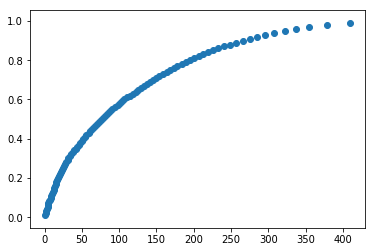

In [223]:
import matplotlib.pyplot as plt
plt.scatter(curva.n_componentes, curva.var_exp)
plt.show()

In [224]:
curva

,n_componentes,var_exp
0.01,1,0.01
0.02,2,0.02
0.03,2,0.03
0.04,3,0.04
0.05,4,0.05
0.06,4,0.06
0.07,5,0.07
0.08,6,0.08
0.09,7,0.09
0.10,8,0.10


In [343]:
pca = TruncatedSVD(n_components = 21)
pca=pca.fit(features)
Xall = pca.transform(features)

Xall=pd.DataFrame(Xall)

In [ ]:
pca = TruncatedSVD(n_components = 21)
pca=pca.fit(features)
Xall = pca.transform(features)

Xall=pd.DataFrame(Xall)


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(Xall)
Xall=scaler.transform(Xall)

clf =XGBClassifier()


cval=respuestas_etiquetas
pred_cval=cross_val_predict(clf, Xall, x_target, cv=10)
cval['pred_cval']=pred_cval

In [344]:
pd.concat([respuestas_etiquetas[['categ_opi', 'texto', 'texto_proc']],  Xall],axis=1).to_csv('./datos/explora_loadings.csv')

In [345]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(Xall)
Xall=scaler.transform(Xall)

In [347]:
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier

#clf = MultinomialNB().fit(Xall, x_target)
#clf =XGBClassifier(colsample_bytree=0.8, gamma=0,max_depth=3,
#                                   min_child_weight=1,missing=None,  n_estimators=100)
#

clf =XGBClassifier()

#clf=clf.fit(Xall, x_target)


In [348]:
x_target.value_counts()

pregunta                  323
otra                      275
otra_queja                143
respuesta                  82
informacion                69
pregunta_busca trabajo     61
nacimiento                 13
emergencia                 10
Name: categ_opi, dtype: int64

In [349]:
from sklearn.model_selection import cross_val_predict
cval=respuestas_etiquetas
pred_cval=cross_val_predict(clf, Xall, x_target, cv=10)
cval['pred_cval']=pred_cval

### Pruebas número de factores

In [354]:
itera=pd.DataFrame()
for i in range(2, 150):
    print(i)
    pca = TruncatedSVD(n_components = i)
    pca=pca.fit(features)
    Xall = pca.transform(features)
    
    Xall=pd.DataFrame(Xall)
    
    
    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler().fit(Xall)
    Xall=scaler.transform(Xall)
    
    clf =XGBClassifier()
    
    
    cval=respuestas_etiquetas
    pred_cval=cross_val_predict(clf, Xall, x_target, cv=10)
    cval['pred_cval']=pred_cval
    precision=sum(np.diagonal(pd.crosstab(cval.categ_opi,  cval.pred_cval, normalize=True)))
    precision=pd.DataFrame({'precision':precision, 'n_loadings':i}, index=[i])
    itera=pd.concat([itera, precision])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


KeyboardInterrupt: 

In [359]:
itera

,n_loadings,precision
2,2,0.434426
3,3,0.108607
4,4,0.087090
5,5,0.101434
6,6,0.461066
7,7,0.090164
8,8,0.090164
9,9,0.080943
10,10,0.085041
11,11,0.071721


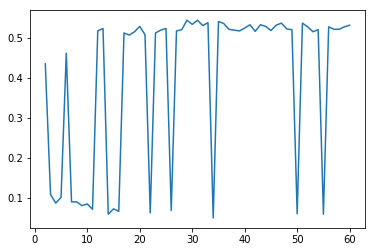

In [358]:
plt.plot(itera.n_loadings, itera.precision)
plt.show()

In [377]:
prueba_listas

,12m,all,altopd,cita,con_fecha,cr-grupo-dm,cr-todos,mialta,no,personal_salud,personal_salud_ow,personal_salud_tw,pregnant,pregnant_ms,pregnant_ms_ow,pregnant_ms_tw,pregnant_ow,pregnant_tw,puerperium,puerperium_ms,puerperium_ms_ow,puerperium_ms_tw,puerperium_ow,puerperium_tw,vacunas
indice,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelo con pura metadata

#### Listas

In [385]:
#pca = TruncatedSVD(n_components = 40)
#pca=pca.fit(features)
#Xall = pca.transform(features)
#
#Xall=pd.DataFrame(Xall)


#from sklearn.preprocessing import MinMaxScaler
#scaler=MinMaxScaler().fit(Xall)
#Xall=scaler.transform(Xall)

clf =XGBClassifier(random_state=1003410)


cval=respuestas_etiquetas
pred_cval=cross_val_predict(clf, prueba_listas, x_target, cv=10)
cval['pred_cval']=pred_cval


In [386]:
pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=False)

pred_cval,nacimiento,otra,pregunta,respuesta
categ_opi,,,,
emergencia,0,1,8,1
informacion,0,5,63,1
nacimiento,2,2,6,3
otra,3,26,235,11
otra_queja,0,7,136,0
pregunta,3,19,299,2
pregunta_busca trabajo,0,4,57,0
respuesta,3,18,55,6


In [387]:
sum(np.diagonal(pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=True)))

0.022540983606557374

#### WC

In [401]:
clf =XGBClassifier(random_state=10542344)


cval=respuestas_etiquetas
pred_cval=cross_val_predict(clf, respuestas_etiquetas[['wc', 'es', 'n_interrogacion']], x_target, cv=10)
cval['pred_cval']=pred_cval

In [402]:
print(sum(np.diagonal(pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=True))))
pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=False)


0.147540983607


pred_cval,informacion,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta
categ_opi,,,,,,
emergencia,0,4,2,3,0,1
informacion,1,23,3,41,0,1
nacimiento,0,8,0,1,0,4
otra,8,92,17,120,3,35
otra_queja,0,30,47,66,0,0
pregunta,2,56,16,248,0,1
pregunta_busca trabajo,0,13,4,43,1,0
respuesta,0,25,0,5,0,52


#### wc + emojis + interrogacion + listas

In [405]:
prueba_meta=pd.concat([respuestas_etiquetas[['wc', 'es', 'n_interrogacion']], prueba_listas], axis=1)

In [409]:
clf =XGBClassifier(random_state=102254256)


cval=respuestas_etiquetas
pred_cval=cross_val_predict(clf, prueba_meta, x_target, cv=10)
cval['pred_cval']=pred_cval

print(sum(np.diagonal(pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=True))))
pd.crosstab(cval.categ_opi,cval.pred_cval, normalize=False)

0.463114754098


pred_cval,emergencia,informacion,nacimiento,otra,otra_queja,pregunta,pregunta_busca trabajo,respuesta
categ_opi,,,,,,,,
emergencia,0,0,0,3,2,4,0,1
informacion,0,0,1,27,3,38,0,0
nacimiento,1,0,4,3,0,3,0,2
otra,0,1,2,107,18,115,2,30
otra_queja,0,0,0,31,48,64,0,0
pregunta,0,3,1,61,14,243,0,1
pregunta_busca trabajo,0,0,0,17,5,39,0,0
respuesta,0,0,5,22,0,5,0,50


In [145]:
test=respuestas_etiquetas.texto_proc

In [146]:
tfidf_matrix_test = tfidf.transform(test)



In [147]:
print(clf.predict(tfidf.transform([' '.join(tokenize_and_stem('busco trabajo adjunto mi cv estudie enfermeria hay vacantes'))])))

ValueError: dimension mismatch

In [123]:
pd.DataFrame(clf.predict(features))[0].value_counts()



pregunta                  613
otra                      223
otra_queja                104
pregunta_busca trabajo     22
informacion                13
respuesta                   1
Name: 0, dtype: int64

In [126]:
test.loc[clf.predict(features)=='informacion']

160    estoy intent comunic con usted al sin embarg m...
242    su numer de telefon y extension par informacio...
254                                  algun numer telefon
308    muy disculp podri proporcion algun numer telef...
310    disculp que utilic este medi es par pregunt po...
357             me gustari qe me pas algun numer telefon
450    que tal me podri proporcion el numer de la ext...
456    escrib de la cd de mer teng problem par comuni...
490    que tal podri proporcion el numer telefon de u...
568    quis envi mi cv soy reci egres de la carrer de...
635                                 cual es su extension
739    sobr la campan de vasectomi estam hac difusion...
902    se solicit permut por cambi de domicili del in...
Name: texto_proc, dtype: object

In [310]:
terms = tfidf_vectorizer.get_feature_names()